# Assignment 3 - Q3 (SVHN)

In [30]:
import torch
from torch import nn
from torch.autograd import  Variable
from torch import optim
from torch.functional import F
from classify_svhn import get_data_loader

import GAN  # needed to allow the reload
import vae
import importlib
importlib.reload(GAN)
importlib.reload(vae)
from GAN import Generator, Discriminator
from vae import VAE

import matplotlib.pyplot as plt

lr = 0.0001
betas = (0, 0.9)
batch_size = 64
z_size = 100
im_size = 32
n_critic = 5
num_epoch = 10

if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Running on cpu")
    device = torch.device("cpu")
    
vae_model = VAE(type='SVHN').to(device)
vae_optim = optim.Adam(vae_model.parameters(), lr=lr, betas=betas)
    
G = Generator(z_size).to(device)
D = Discriminator(im_size, device).to(device)

g_optim = optim.Adam(G.parameters(), lr=lr, betas=betas)
d_optim = optim.Adam(D.parameters(), lr=lr, betas=betas)

Using cuda


## Data

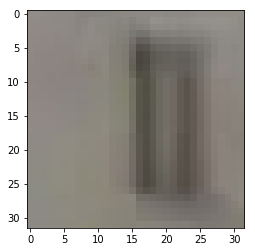

In [3]:
def showImg(x):
    x = x.permute(1, 2, 0)
    plt.imshow((x.numpy() * 0.5) + 0.5)
    
train_loader, valid_loader, test_loader = get_data_loader("svhn", batch_size)

# Show an image
real_sample, target = next(iter(train_loader))

showImg(real_sample[0])

In [ ]:
def train(loader):
    d_train_loss = 0
    
    for epoch in range(num_epoch):
        
        for data_idx, real_sample in enumerate(loader):
            G.train()
            D.train()
            
            step = epoch * len(loader) + data_idx + 1
            
            # Train more the dicriminator
            d_optim.zero_grad()
            g_optim.zero_grad()
    
            z = Variable(torch.randn(batch_size, z_size, device=device))
            
            fake_sample = G(z)
            real_sample = real_sample.to(device)
            
            d_loss = D.loss(real_sample, fake_sample)
            d_loss.backward()
            d_optim.step()
    
            if step % n_critic == 0:
                # Train the generator
                d_optim.zero_grad()
                g_optim.zero_grad()
            
                z = Variable(torch.randn(batch_size, z_size, device=device))
            
                fake_sample = G(z)
                fake_result = D(fake_sample)
                g_loss = G.loss(fake_result)
                g_loss.backward()
                g_optim.step()
                
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, d_train_loss / len(loader.dataset)))
        
        createSample(G)

In [ ]:
def createSample(generator):
    generator.eval()
    
    z = Variable(torch.randn(z_size, device=device))
    im = generator(z)
    showImg(im)

In [ ]:
train(train_loader)

## VAE training

In [42]:
def ELBO_loss_function(recon_x, x, mu, logvar):
    # ELBO: L(θ, φ; x) = -E_z~q_φ[log p_θ(x|z)] + D_KL(q_φ(z|x)||p(z))
    # reconstruction loss + regularizer (forcing the encoder's output to stay close to a standard Normal distribution)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    batch_size = x.shape[0]
    
    return (MSE + KLD) / batch_size


def train_vae(model, num_epoch, train_loader, optimizer):
    for epoch in range(num_epoch):
        train_loss = 0
        for batch_idx, (data, y) in enumerate(train_loader):
            data = data.to(device)
            flattened_data = data.view(-1, 3072)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(flattened_data)
            loss = ELBO_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader)))

In [43]:
train_vae(vae_model, num_epoch, train_loader, vae_optim)

Train Epoch: 0 [0/65931 (0%)]	Loss: 365.391602
Train Epoch: 0 [6400/65931 (10%)]	Loss: 335.915527
Train Epoch: 0 [12800/65931 (19%)]	Loss: 331.953491
Train Epoch: 0 [19200/65931 (29%)]	Loss: 298.137360
Train Epoch: 0 [25600/65931 (39%)]	Loss: 329.961792
Train Epoch: 0 [32000/65931 (48%)]	Loss: 309.068909
Train Epoch: 0 [38400/65931 (58%)]	Loss: 311.034851
Train Epoch: 0 [44800/65931 (68%)]	Loss: 309.366821
Train Epoch: 0 [51200/65931 (78%)]	Loss: 311.298859
Train Epoch: 0 [57600/65931 (87%)]	Loss: 314.777618
Train Epoch: 0 [64000/65931 (97%)]	Loss: 317.983704
====> Epoch: 0 Average loss: 325.9786
Train Epoch: 1 [0/65931 (0%)]	Loss: 295.957458
Train Epoch: 1 [6400/65931 (10%)]	Loss: 319.064331
Train Epoch: 1 [12800/65931 (19%)]	Loss: 263.191925
Train Epoch: 1 [19200/65931 (29%)]	Loss: 284.173859
Train Epoch: 1 [25600/65931 (39%)]	Loss: 279.227448
Train Epoch: 1 [32000/65931 (48%)]	Loss: 282.745361
Train Epoch: 1 [38400/65931 (58%)]	Loss: 286.708435
Train Epoch: 1 [44800/65931 (68%)]	Los